# Mapping human fetal thymus Visium sections with fetal reference

## Loading packages <a class="anchor" id="Loading_packages"></a>

In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl

import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

Global seed set to 0
/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to show output from all the lines in a cells
pd.set_option('display.max_column',None) # display all the columns in pandas
pd.options.display.max_rows = 100
from datetime import date
today = str(date.today())
sc.settings.set_figure_params(dpi = 150, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'pdf')

sc.settings.verbosity = 1
sc.logging.print_version_and_date()
%load_ext autoreload
%autoreload 2

Running Scanpy 1.9.1, on 2023-08-02 10:15.


First, let's define where we save the results of our analysis:

In [3]:
results_folder = '/nfs/team205/vk8/projects/thymus_atlas/results/thymus_atlas_v2_anno_v11_fetal_sub_10K'
# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

## Loading scRNA-seq reference data <a class="anchor" id="Loading_Visium"></a>

In [4]:
adata_ref_all = sc.read("/nfs/team205/ny1/ThymusSpatialAtlas/Figure1/annotation_done/Thymus_Atlas_v8_postQC.h5ad")

# clean object 

In [5]:
adata_ref = adata_ref_all[adata_ref_all.obs['age_group'] == 'fetal', :].copy() # subset to fetal 
del adata_ref_all
adata_ref

AnnData object with n_obs × n_vars = 154163 × 36751
    obs: 'n_genes', 'sample_barcode', 'batch', 'chemistry', 'age_group', 'age_numeric', 'sampleID_TCRab', 'path_TCRab', 'type', 'study', 'sample', 'enrichment', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'barcode_sequence', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'status', 'assignment', 'log_prob_singleton', 'log_prob_doublet', 'louvian_1', 'louvian_05', 'latent_cell_probability', 'latent_RT_efficiency', 'log1p_n_counts', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_r

In [6]:
adata_ref = adata_ref[:,~adata_ref.var['cite']] # remove cite genes
adata_ref


View of AnnData object with n_obs × n_vars = 154163 × 36601
    obs: 'n_genes', 'sample_barcode', 'batch', 'chemistry', 'age_group', 'age_numeric', 'sampleID_TCRab', 'path_TCRab', 'type', 'study', 'sample', 'enrichment', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'barcode_sequence', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'status', 'assignment', 'log_prob_singleton', 'log_prob_doublet', 'louvian_1', 'louvian_05', 'latent_cell_probability', 'latent_RT_efficiency', 'log1p_n_counts', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_cou

In [7]:
adata_ref.obs['study'].value_counts()

Park2020        101095
Bautista2021     53068
Name: study, dtype: int64

In [8]:
adata_ref.obs['cell_type_level_4'].value_counts().loc[adata_ref.obs['cell_type_level_4'].value_counts()<=40]

Monocyte_CCR2    38
aDC2             36
CMP              30
Neutrophil       26
Myelocyte        18
B_pro_pre        16
pDC-Prolif       14
large_pre_B      12
B-plasma          7
Name: cell_type_level_4, dtype: int64

In [9]:
# remove cells for fetal 
#to_remove = ['T_SP-HSP','T_DP(Q)-HSPH1','cTECIII','Fb-SBSPON','Mesothelium','Mural',
#             'Pericyte_CCL19','ProlifPericyte','B-stimulated','DC-Prolif','TEC-tuft',
#             'medFb-PDGFRAlo','T_DN(Q)-CD99','T_DN(CD4)-CD99','T_DP(Q)-early','plasma-cells']
to_remove = ['T_DP(Q)-HSPH1','T_SP8or4','T_SP-HSP','T_DN(Q)-stress_1','T_DN(Q)-stress_2',
  'T_DN(Q)-intermediate','T_Treg-intermediate', 'B-plasma', 'large_pre_B', 'pDC-Prolif']
adata_ref = adata_ref[~adata_ref.obs['cell_type_level_4'].isin(to_remove),:].copy()
adata_ref

AnnData object with n_obs × n_vars = 144745 × 36601
    obs: 'n_genes', 'sample_barcode', 'batch', 'chemistry', 'age_group', 'age_numeric', 'sampleID_TCRab', 'path_TCRab', 'type', 'study', 'sample', 'enrichment', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'barcode_sequence', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'status', 'assignment', 'log_prob_singleton', 'log_prob_doublet', 'louvian_1', 'louvian_05', 'latent_cell_probability', 'latent_RT_efficiency', 'log1p_n_counts', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_r

In [10]:
# downsample source 
target_cells = 10000
target_cells_subclass = 3000
cluster_key = 'cell_type_level_4'
adatas = [adata_ref[adata_ref.obs[cluster_key].isin([clust])] for clust in list(adata_ref.obs[cluster_key].cat.categories)]

for dat in adatas:
    if dat.n_obs > target_cells_subclass:
        if np.unique(dat.obs['cell_type_level_4'].isin(['PeriloFb', 'InterloFb', 'EC-Art', 'EC-Ven']))[0]:
            sc.pp.subsample(dat, n_obs=target_cells_subclass)
        else:
            if dat.n_obs > target_cells:
                sc.pp.subsample(dat, n_obs=target_cells)

adata_ref = adatas[0].concatenate(*adatas[1:])
adata_ref.obs['cell_type_level_4'].value_counts()

/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


EC-Cap              10000
T_DP(Q)             10000
T_DP(P)             10000
T_DN(Q)              9435
T_DN(P)              6622
T_αβT(entry)         6267
T_CD4                4295
T_DP(Q)-early        3870
cTECI                3393
Pericyte             3287
SMC                  3128
InterloFb            3000
EC-Art               3000
EC-Ven               3000
PeriloFb             3000
T_CD8                2920
T_CD8αα(I)           2322
T_Treg(agonist)      1741
EC-Cap-Prolif        1620
mcTEC                1611
mcTEC-Prolif         1563
medFb                1373
PeriloFb-Prolif      1347
T_DP(Q)-CD99         1308
T_Treg_recirc        1214
T_cycling            1173
InterloFb-COL9A3     1087
T_DN(early)          1070
mTECI                1054
T_NK_fetal            804
EC-Ven-ELN            607
T_γδT                 604
T_innate_type_3       587
T_NK                  563
TEC-myo               547
T_CD8αα(entry)        524
Pericyte_COL1A1       513
Pericyte_CCL19        512
T_CD8-Prolif

# downsample source 
target_cells = 50000
target_cells_subclass = 1000
cluster_key = 'cell_type_level_4'
adatas = [adata_ref[adata_ref.obs[cluster_key].isin([clust])] for clust in list(adata_ref.obs[cluster_key].cat.categories)]

for dat in adatas:
    if dat.n_obs > target_cells_subclass:
        if np.unique(dat.obs['cell_type_level_4'].isin(['PeriloFb', 'EC-Ven', 'EC-Cap', 'EC-Art', 'InterloFb','Pericyte', 'SMC', 'medFb']))[0]:
            sc.pp.subsample(dat, n_obs=target_cells_subclass)
        else:
            if dat.n_obs > target_cells:
                sc.pp.subsample(dat, n_obs=target_cells)

adata_ref = adatas[0].concatenate(*adatas[1:])
adata_ref.obs['cell_type_level_4'].value_counts()

## Highly variable gene selection

View of AnnData object with n_obs × n_vars = 119141 × 36005
    obs: 'n_genes', 'sample_barcode', 'batch', 'chemistry', 'age_group', 'age_numeric', 'sampleID_TCRab', 'path_TCRab', 'type', 'study', 'sample', 'enrichment', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'barcode_sequence', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'status', 'assignment', 'log_prob_singleton', 'log_prob_doublet', 'louvian_1', 'louvian_05', 'latent_cell_probability', 'latent_RT_efficiency', 'log1p_n_counts', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_cou

/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/cell2location/utils/filtering.py:26: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = np.array((adata.X > 0).sum(0)).flatten()
/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


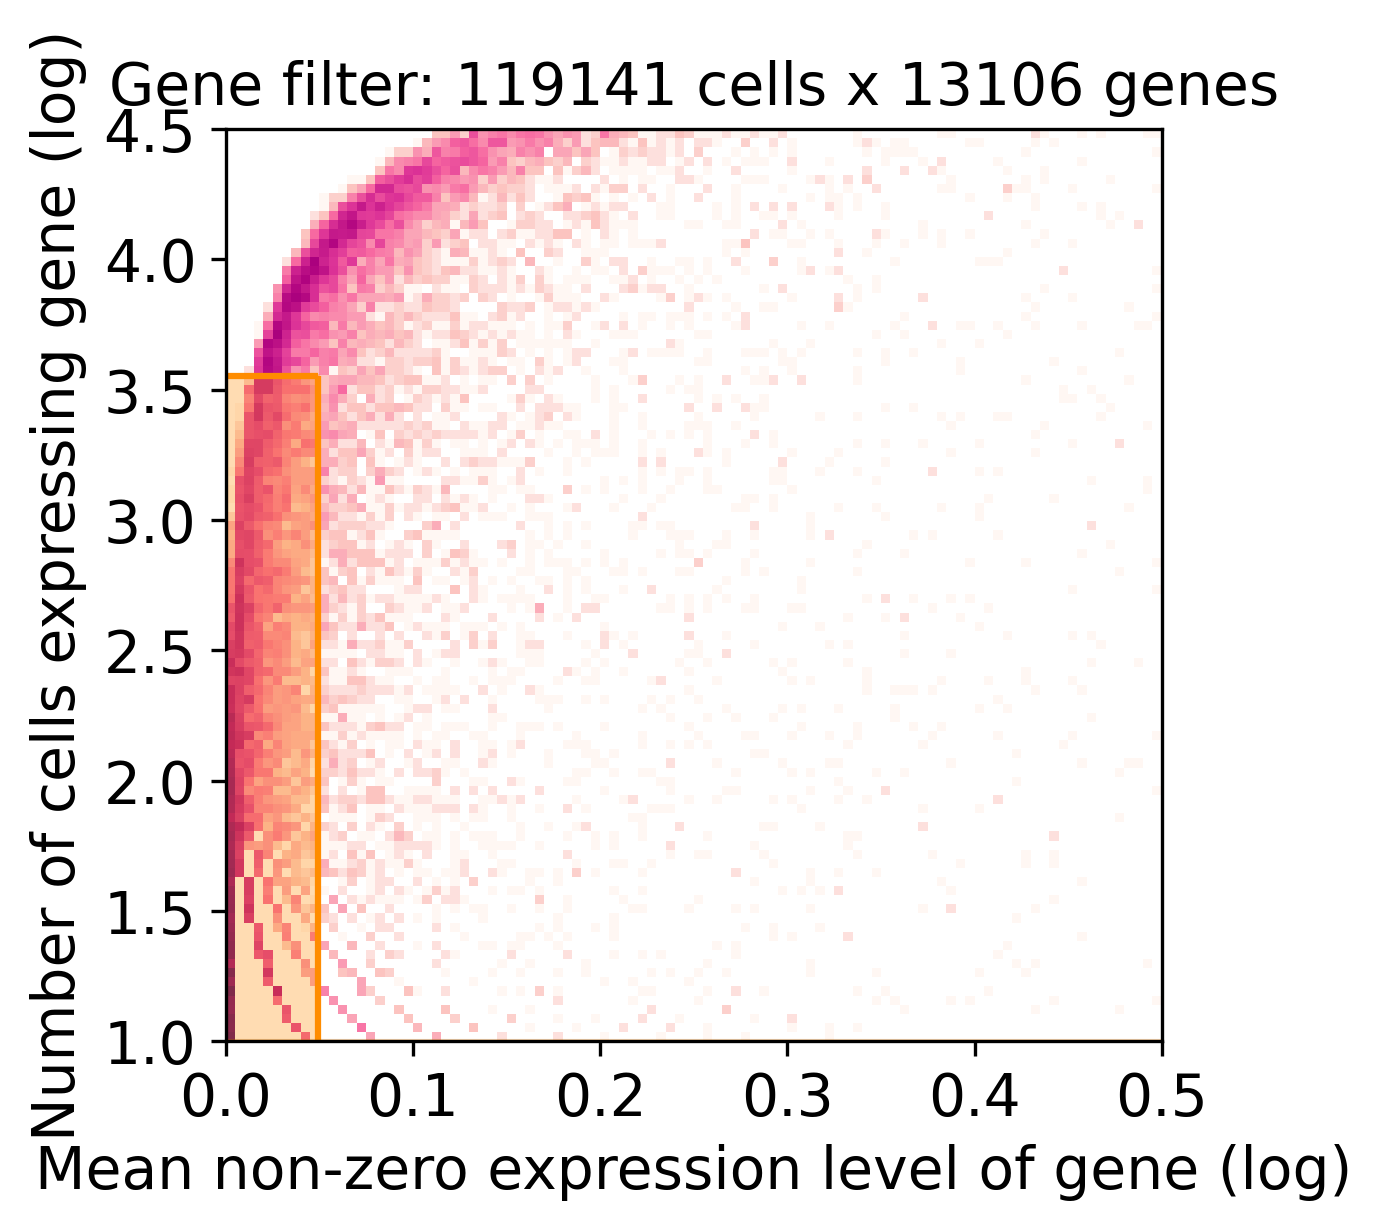

In [11]:
# remove vdj genes
import re
adata_ref.var['vdj'] = False
for i in adata_ref.var.index:
    if re.search('^TR[AB][VDJ]|^IG[HKL][VDJC]', i):
        adata_ref.var.at[i, 'vdj'] = True
adata_ref = adata_ref[:,~adata_ref.var['vdj']]
adata_ref


cc_genes =  ['C1orf112', 'KDM1A', 'ARHGAP33', 'CDC27', 'AC004381.6', 'DBF4', 'PRSS21', 'E2F2', 'BAZ1B', 'NCAPD2', 'ANLN', 'BRCA1', 'UBR7', 'DDX11', 'TACC3', 'POLA2', 'DEPDC1', 'NCAPH2', 'HMGB3', 'CENPQ', 'DEPDC1B', 'SPDL1', 'TDP1', 'DSG2', 'NOP16', 'RFC2', 'RAD51', 'POLQ', 'THOC3', 'MRTO4', 'C4orf27', 'POLD1', 'TM7SF3', 'MCM10', 'MTHFD2', 'YBX1', 'ASPM', 'PRR11', 'NUCKS1', 'EXOC5', 'TCOF1', 'RAD18', 'TRIP13', 'DAZAP1', 'HLTF', 'PDCD2', 'SMC1A', 'HMMR', 'MCM2', 'NUP37', 'GTSE1', 'WDR62', 'MCM6', 'MLH1', 'UNG', 'SPAG5', 'UBE2T', 'EXOSC5', 'FAM76B', 'POLD3', 'KIF22', 'PUM3', 'RBL1', 'NDC80', 'HSPB11', 'OXCT1', 'SEH1L', 'ORC1', 'RAD54L', 'NOP14', 'GMCL1', 'AURKA', 'TPX2', 'BIRC5', 'KIF4A', 'FH', 'ORC6', 'G2E3', 'WDR76', 'PHGDH', 'CLSPN', 'NUP50', 'CDC45', 'CDC6', 'CBX5', 'MSH2', 'FKBP5', 'ACOT7', 'CDC7', 'RANBP1', 'CENPM', 'HMGXB4', 'MCM5', 'RANGAP1', 'POLE2', 'CDKN3', 'ERH', 'MTHFD1', 'VRK1', 'EMC9', 'GINS1', 'MYBL2', 'CDC25B', 'PLCB4', 'FAM83D', 'CEP76', 'RBBP8', 'POLA1', 'NUP93', 'CTCF', 'CCP110', 'CEP152', 'OIP5', 'MYEF2', 'MCM4', 'KCTD9', 'RNASEH2A', 'SGTA', 'ASF1B', 'LIG1', 'H2AFV', 'GARS', 'NUDT1', 'RPA3', 'EZH2', 'RHEB', 'SMC3', 'UBE2S', 'RAD51C', 'GALK1', 'C1QBP', 'BLMH', 'TMEM97', 'GAR1', 'NEIL3', 'WHSC1', 'NCAPG', 'CCDC34', 'CCDC86', 'MAGOHB', 'FOXM1', 'GPN3', 'RAD51AP1', 'RFC5', 'NUP107', 'TIMELESS', 'GAPDH', 'CDCA3', 'ENO2', 'FBXO5', 'MCM3', 'BAG2', 'GMNN', 'TTK', 'HMGCS1', 'BRD8', 'KIF20A', 'LMNB1', 'NUP155', 'H2AFY', 'SMC4', 'ECT2', 'CENPA', 'FHL2', 'MSH6', 'DHCR24', 'LRRC42', 'WDR77', 'SRM', 'MAD2L2', 'UCHL5', 'TTF2', 'SLC2A1', 'EBNA1BP2', 'CDC20', 'STMN1', 'NEK2', 'CENPF', 'KIF14', 'CASP8AP2', 'CTNNAL1', 'WDR34', 'PHF19', 'ACYP1', 'EPCAM', 'HELLS', 'CENPL', 'ACAT2', 'MASTL', 'EXOSC8', 'TMPO', 'NFYB', 'NCAPH', 'MND1', 'KIF18A', 'GPSM2', 'GTF3A', 'MRPS2', 'CCDC18', 'CISD1', 'ZWINT', 'CIT', 'DDX39A', 'CENPK', 'CDK2', 'TUBA1B', 'STIL', 'HJURP', 'EXOSC9', 'CKS2', 'ACSL3', 'CSE1L', 'HIST1H1D', 'HIST1H1A', 'DEK', 'GOT2', 'MGME1', 'MCM8', 'HNRNPR', 'BCL2L12', 'TRAP1', 'DLGAP5', 'YEATS4', 'PKMYT1', 'SRD5A3', 'PAICS', 'HAT1', 'KNSTRN', 'DUT', 'E2F8', 'FAM64A', 'MIS18BP1', 'SGOL1', 'RPS4Y1', 'LDLR', 'TOMM40', 'ATP8B3', 'LSM4', 'DNMT1', 'GINS2', 'TUBG1', 'PSMC3IP', 'THOC6', 'TOP2A', 'ENOSF1', 'RAN', 'RPA1', 'PCNA', 'NASP', 'RFC3', 'SLF1', 'LRRCC1', 'CCNB1', 'PSRC1', 'TMEM106C', 'LDHA', 'DDB2', 'CDCA8', 'TPGS2', 'SLC43A3', 'C9orf40', 'TROAP', 'ESPL1', 'NTPCR', 'CKAP2', 'BORA', 'NUDT15', 'BRIP1', 'ACTL6A', 'TXN', 'ODF2', 'SMC2', 'CDK5RAP2', 'ANP32B', 'DSCC1', 'ARHGEF39', 'PPIL1', 'TCF19', 'NRM', 'GGH', 'BUD13', 'CTDSPL2', 'NUSAP1', 'KIF23', 'CASC5', 'CENPO', 'KIF11', 'CEP55', 'KIF20B', 'DNA2', 'BARD1', 'MNS1', 'ZGRF1', 'CENPE', 'HADH', 'SLC39A8', 'NEDD1', 'BRCA2', 'DIAPH3', 'PIF1', 'FANCI', 'TICRR', 'SAMD1', 'SAE1', 'PLK4', 'ITGB3BP', 'KIF2C', 'UCK2', 'NUF2', 'ANP32E', 'DTL', 'ILF2', 'C1orf35', 'HNRNPLL', 'CHAC2', 'POLR2D', 'CDCA7', 'FANCD2', 'CCNA2', 'SKP2', 'PRIM2', 'MMS22L', 'PM20D2', 'MTFR2', 'CDCA5', 'NCAPG2', 'PRPS1', 'GINS4', 'HAUS6', 'CEP78', 'GTF3C5', 'MKI67', 'IMMP1L', 'SSRP1', 'INCENP', 'CCDC15', 'CHEK1', 'DSN1', 'HIRIP3', 'HMGA2', 'TEX30', 'NCAPD3', 'CENPU', 'CENPJ', 'SPC25', 'SUV39H2', 'CENPH', 'CARHSP1', 'CLGN', 'CCSAP', 'BUB3', 'SLFN13', 'SKA1', 'SLC16A1', 'TMEM237', 'ADK', 'FAM122B', 'AIFM1', 'ATAD2', 'SASS6', 'BUB1B', 'CCNB2', 'PSMG3', 'FAIM', 'CDC25C', 'MIS18A', 'ATP5G1', 'IGF2BP1', 'CHAF1B', 'NAE1', 'CCDC58', 'C21orf58', 'ZNF714', 'GPATCH4', 'YDJC', 'RACGAP1', 'SPC24', 'POLR3K', 'CCNF', 'ASRGL1', 'USP1', 'KIAA1524', 'SGOL2', 'TOPBP1', 'KIF15', 'WDR43', 'RFC4', 'RPL39L', 'RNF168', 'H2AFZ', 'CDC25A', 'POC1A', 'HMGB2', 'MAD2L1', 'PTTG1', 'RAD21', 'PSIP1', 'GKAP1', 'MELK', 'SLC7A3', 'SKA3', 'LRR1', 'HPRT1', 'E2F7', 'JAM3', 'BRD7', 'CENPN', 'LEO1', 'WEE1', 'MCM7', 'CENPV', 'SAAL1', 'FAM111A', 'KIAA0101', 'PLK1', 'XRCC6BP1', 'SNRPD1', 'RRM1', 'CDT1', 'CHAF1A', 'C19orf48', 'NUDT8', 'PRDX2', 'TK1', 'SAC3D1', 'PBK', 'HIST1H1E', 'DTYMK', 'RFWD3', 'FEN1', 'ING2', 'CDKN2AIP', 'SNRNP48', 'USP39', 'CKAP2L', 'BUB1', 'ELP5', 'CDK1', 'CDCA4', 'SHCBP1', 'PGAM1', 'ESCO2', 'RHNO1', 'CTPS1', 'RRM2', 'THOP1', 'C5orf34', 'POP7', 'ZNF738', 'CKS1B', 'GMPPB', 'CNP', 'CBX2', 'C16orf91', 'EXO1', 'ZWILCH', 'ANKRD36C', 'UBE2C', 'CKAP5', 'CCNE2', 'CCDC14', 'RMI2', 'TOMM5', 'RUVBL1', 'ATAD5', 'LMNB2', 'TYMS', 'PXMP2', 'SHMT1', 'POLE', 'PAWR', 'PIDD1', 'GSG2', 'GEN1', 'RMI1', 'AURKB', 'RCC1', 'PPA1', 'HIST3H2A', 'MRPS23', 'RTKN2', 'IDH2', 'KPNA2', 'CEP97', 'GLRX5', 'SKA2', 'CEP57L1', 'PSMG1', 'SFXN4', 'ALYREF', 'TRAIP', 'LIN9', 'KMT5A', 'PGP', 'CMSS1', 'HIST2H2AC', 'HIST1H1B', 'KNTC1', 'CDCA2', 'H1FX', 'SIVA1', 'PARPBP', 'KIF18B', 'ERCC6L', 'PTMA', 'HSPA14', 'FANCA', 'ARHGAP11B', 'TUBB4B', 'CENPP', 'H2AFX', 'FAM72B', 'FAM221A', 'FAM111B', 'HN1', 'HMGB1', 'TUBB', 'IARS', 'ERI2', 'HIST1H4C', 'BLM', 'PRIM1', 'HMGN5', 'SVIP', 'TFDP1', 'TXNRD1', 'WDHD1', 'EIF1AY', 'ARHGAP11A', 'HMGN2', 'DCAF12', 'PRC1', 'CCDC167', 'CENPW', 'GPANK1', 'MZT1', 'C4orf46', 'KLHL23', 'MXD3', 'DNAJC9', 'IFRD2', 'CKLF', 'FANCG', 'DHFR', 'DLEU2', 'AP000251.3', 'KIFC1', 'CRNDE', 'C8orf88', 'PRKDC', 'BOP1', 'RP11-196G18.23', 'CTC-260E6.6', 'NCBP2-AS2', 'HIST1H3G', 'HIST1H2AH', 'UHRF1', 'RDM1', 'HIST1H2AM']

def remove_selected_genes(adata,lst,remove_also_mt=True):
    for g in lst:
        adata = adata[:,~(adata.var_names==g)]
    if remove_also_mt:
        adata = adata[:,~(adata.var_names.str.startswith('MT-'))]
    return adata

adata_ref = remove_selected_genes(adata_ref,cc_genes,remove_also_mt=True)  

from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)
adata_ref = adata_ref[:,selected].copy()

sc.pp.highly_variable_genes(
        adata_ref,
        n_top_genes=15000,
        subset=True,
        # layer='counts',
        flavor="seurat_v3",
        batch_key="cell_type_level_4",
        span=1,
    )

In [12]:
# from cell2location.utils.filtering import filter_genes

In [13]:
# selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.05, nonz_mean_cutoff=1.12)

In [14]:
# adata_ref = adata_ref[:, selected].copy()
# adata_ref

## Estimation of reference cell type signatures (NB regression) <a class="anchor" id="Estimating_signatures"></a>

The signatures are estimated from scRNA-seq data, accounting for batch effect, using a Negative binomial regression model.

In [12]:
adata_ref.shape

(119141, 13106)

In [13]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref, 
                        # 10X reaction / sample / batch
                        batch_key='sample', 
                        # cell type, covariate used for constructing signatures
                        labels_key='cell_type_level_4', 
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                        categorical_covariate_keys=['chemistry_simple','study','donor'],
                        continuous_covariate_keys=['age_numeric'],
                       )

In [14]:
# create and train the regressiolayersdel
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref) 
# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.19.0.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': 'cell_type_level_4',
│   'categorical_covariate_keys': ['chemistry_simple', 'study', 'donor'],
│   'continuous_covariate_keys': ['age_numeric']
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   33   │
│         n_cells          │ 119141 │
│ n_extra_categorical_covs │   3    │
│ n_extra_continuous_covs  │   1    │
│         n_labels         │   93   │
│          n_vars          │ 13106  │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│ extra_continuous_covs  │ adata.obsm['_scvi_extra_continuous_covs']  │
│         ind_x          │           adata.obs['_indices']            │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃   Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │  F83_TH_EPCAM  │          0          │
│                     │ FCAImmP7179369 │          1          │
│                     │ FCAImmP7179370 │          2          │
│                     │ FCAImmP7198634 │          3          │
│                     │ FCAImmP7198635 │          4          │
│                     │ FCAImmP7277556 │          5          │
│                     │ FCAImmP7277557 │          6          │
│                     │ FCAImmP7277564 │          7          │
│                     │ FCAImmP7277565 │          8          │
│                     │ FCAImmP7292030 │          9          │
│                     │ FCAImmP7292034 │         10          │
│                     │ FCAImmP7528283 │         11          │
│                     │ FCAImmP7528284 │         12          │
│                     │ FCAImmP7528285 │         13          │
│                     │ FCAImmP7528294 │         14          │
│                     │ FCAImmP7555851 │         15          │
│                     │ FCAImmP7555852 │         16          │
│                     │ FCAImmP7555860 │         17          │
│                     │ FCAImmP7555861 │         18          │
│                     │ FCAImmP7579218 │         19          │
│                     │ FCAImmP7579219 │         20          │
│                     │ FCAImmP7579230 │         21          │
│                     │ FCAImmP7579231 │         22          │
│                     │ FCAImmP7851890 │         23          │
│                     │ FCAImmP7851891 │         24          │
│                     │ FCAImmP7851892 │         25          │
│                     │ FCAImmP7851893 │         26          │
│                     │ FCAImmP7851894 │         27          │
│                     │ FCAImmP7851895 │         28          │
│                     │ FCAImmP7851896 │         29          │
│                     │   GSM4466780   │         30          │
│                     │   GSM4466781   │         31          │
│                     │   GSM4466782   │         32          │
└─────────────────────┴────────────────┴─────────────────────┘

                           labels State Registry                           
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location         ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_type_level_4'] │     B-Prolif     │          0          │
│                                │     B-memory     │          1          │
│                                │     B-naive      │          2          │
│                                │    B_pro_pre     │          3          │
│                                │       CMP        │          4          │
│                                │       DC1        │          5          │
│                                │    DC1-Prolif    │          6          │
│                                │       DC2        │          7          │
│                                │    DC2-Prolif    │          8          │
│                                │      EC-Art      │          9          │
│                                │    EC-Art-ELN    │         10          │
│                                │      EC-Cap      │         11          │
│                                │  EC-Cap-Prolif   │         12          │
│                                │   EC-Lymphatic   │         13          │
│                                │      EC-Ven      │         14          │
│                                │    EC-Ven-ELN    │         15          │
│                                │       GMP        │         16          │
│                                │    InterloFb     │         17          │
│                                │ InterloFb-COL9A3 │         18          │
│                                │ Macrophage-APOC2 │         19          │
│                                │ Macrophage-LYVE1 │         20          │
│                                │ Macrophage-SPIC1 │         21          │
│                                │       Mast       │         22          │
│                                │   Mesothelium    │         23          │
│                                │  Monocyte_CCR2   │         24          │
│                                │  Monocyte_IL1B   │         25          │
│                                │    Myelocyte     │         26          │
│                                │    Neutrophil    │         27          │
│                                │     Pericyte     │         28          │
│                                │  Pericyte_CCL19  │         29          │
│                                │ Pericyte_COL1A1  │         30          │
│                                │     PeriloFb     │         31          │
│                                │ PeriloFb-Prolif  │         32          │
│                                │  ProlifPericyte  │         33          │
│                                │   Promonocyte    │         34          │
│                                │       RBC        │         35          │
│                                │       SMC        │         36          │
│                                │     Schwann      │         37          │
│                                │  TEC-cilliated   │         38          │
│                                │     TEC-myo      │         39          │
│                                │    TEC-neuro     │         40          │
│                                │     TEC-tuft     │         41          │
│                                │      T_CD4       │         42          │
│                                │      T_CD8       │         43          │
│                                │   T_CD8-Prolif   │         44          │
│                                │   T_CD8_memory   │         45          │
│                                │    T_CD8αα(I)    │         46          │
│                                │   T_CD8αα(II)    │         47          │
│                                │  T_CD8αα(entr

                extra_categorical_covs State Registry                 
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location        ┃  Categories  ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['chemistry_simple'] │     3GEX     │          0          │
│                               │     5GEX     │          1          │
│                               │              │                     │
│      adata.obs['donor']       │     F21      │          0          │
│                               │     F23      │          1          │
│                               │     F29      │          2          │
│                               │     F30      │          3          │
│                               │     F38      │          4          │
│                               │     F41      │          5          │
│                               │     F45      │          6          │
│                               │     F64      │          7          │
│                               │     F67      │          8          │
│                               │     F83      │          9          │
│                               │    baut1     │         10          │
│                               │    baut2     │         11          │
│                               │    baut3     │         12          │
│                               │              │                     │
│      adata.obs['study']       │ Bautista2021 │          0          │
│                               │   Park2020   │          1          │
│                               │              │                     │
└───────────────────────────────┴──────────────┴─────────────────────┘

extra_continuous_covs State 
          Registry          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['age_numeric'] │
└──────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:105: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-cabed480-71db-8ae2-d02c-e01d42a2060d/0/0]


Epoch 1/250:   0%|                                                                                                                  | 0/250 [00:00<?, ?it/s]

/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/torch/distributions/gamma.py:71: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /nfs/users/nfs_v/vk8/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  self.rate * value - torch.lgamma(self.concentration))


Epoch 2/250:   0%|▎                                                                            | 1/250 [00:07<29:49,  7.19s/it, v_num=1, elbo_train=8.92e+8]

/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


Epoch 250/250: 100%|█████████████████████████████████████████████████████████████████████████| 250/250 [22:49<00:00,  5.49s/it, v_num=1, elbo_train=5.93e+8]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|█████████████████████████████████████████████████████████████████████████| 250/250 [22:49<00:00,  5.48s/it, v_num=1, elbo_train=5.93e+8]


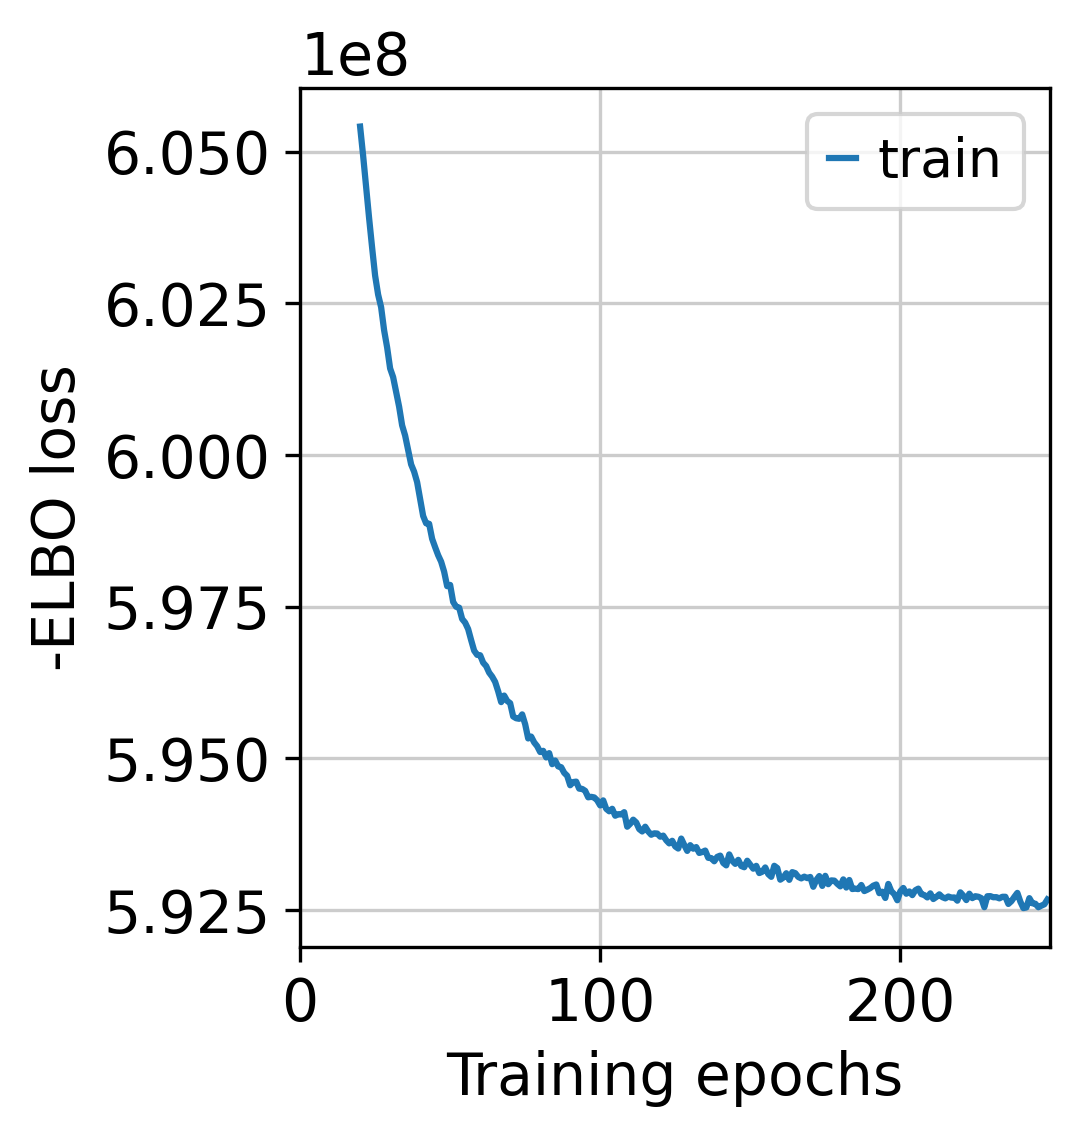

In [15]:
# Use all data for training (validation not implemented yet, train_size=1)
mod.train(max_epochs=250, batch_size=2500, train_size=1, lr=0.002, use_gpu=True)

# plot ELBO loss history during training, removing first 20 epochs from the plot
mod.plot_history(20)

In [16]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

Sampling global variables, sample: 100%|█████████████████████████████████████████████████████████████████████████████████| 999/999 [00:08<00:00, 111.08it/s]


In [17]:
# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref.write(adata_file)
adata_file

'/nfs/team205/vk8/projects/thymus_atlas/results/thymus_atlas_v2_anno_v11_fetal_sub_10K/reference_signatures/sc.h5ad'

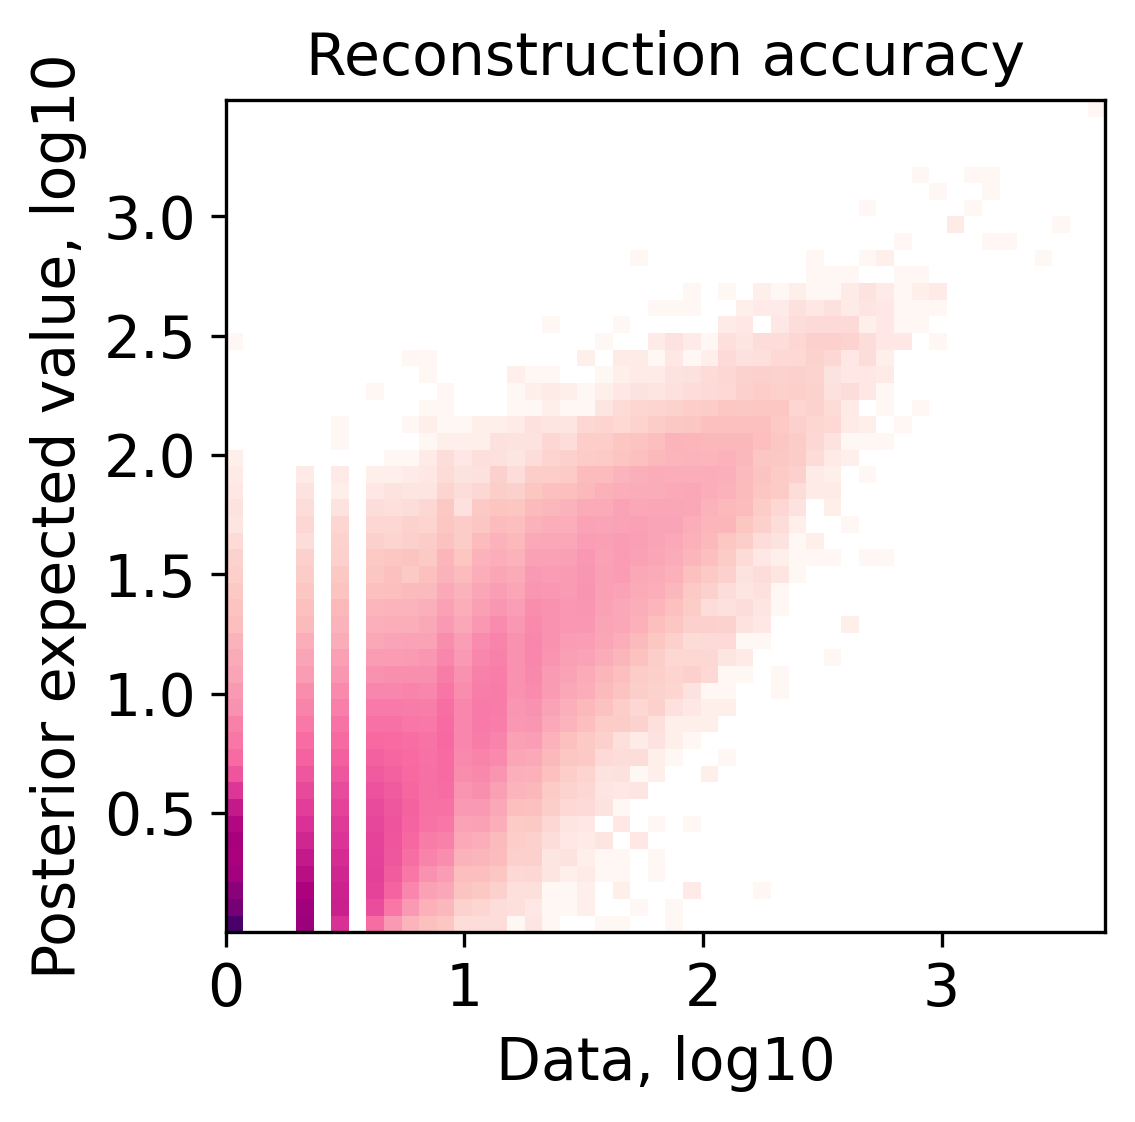

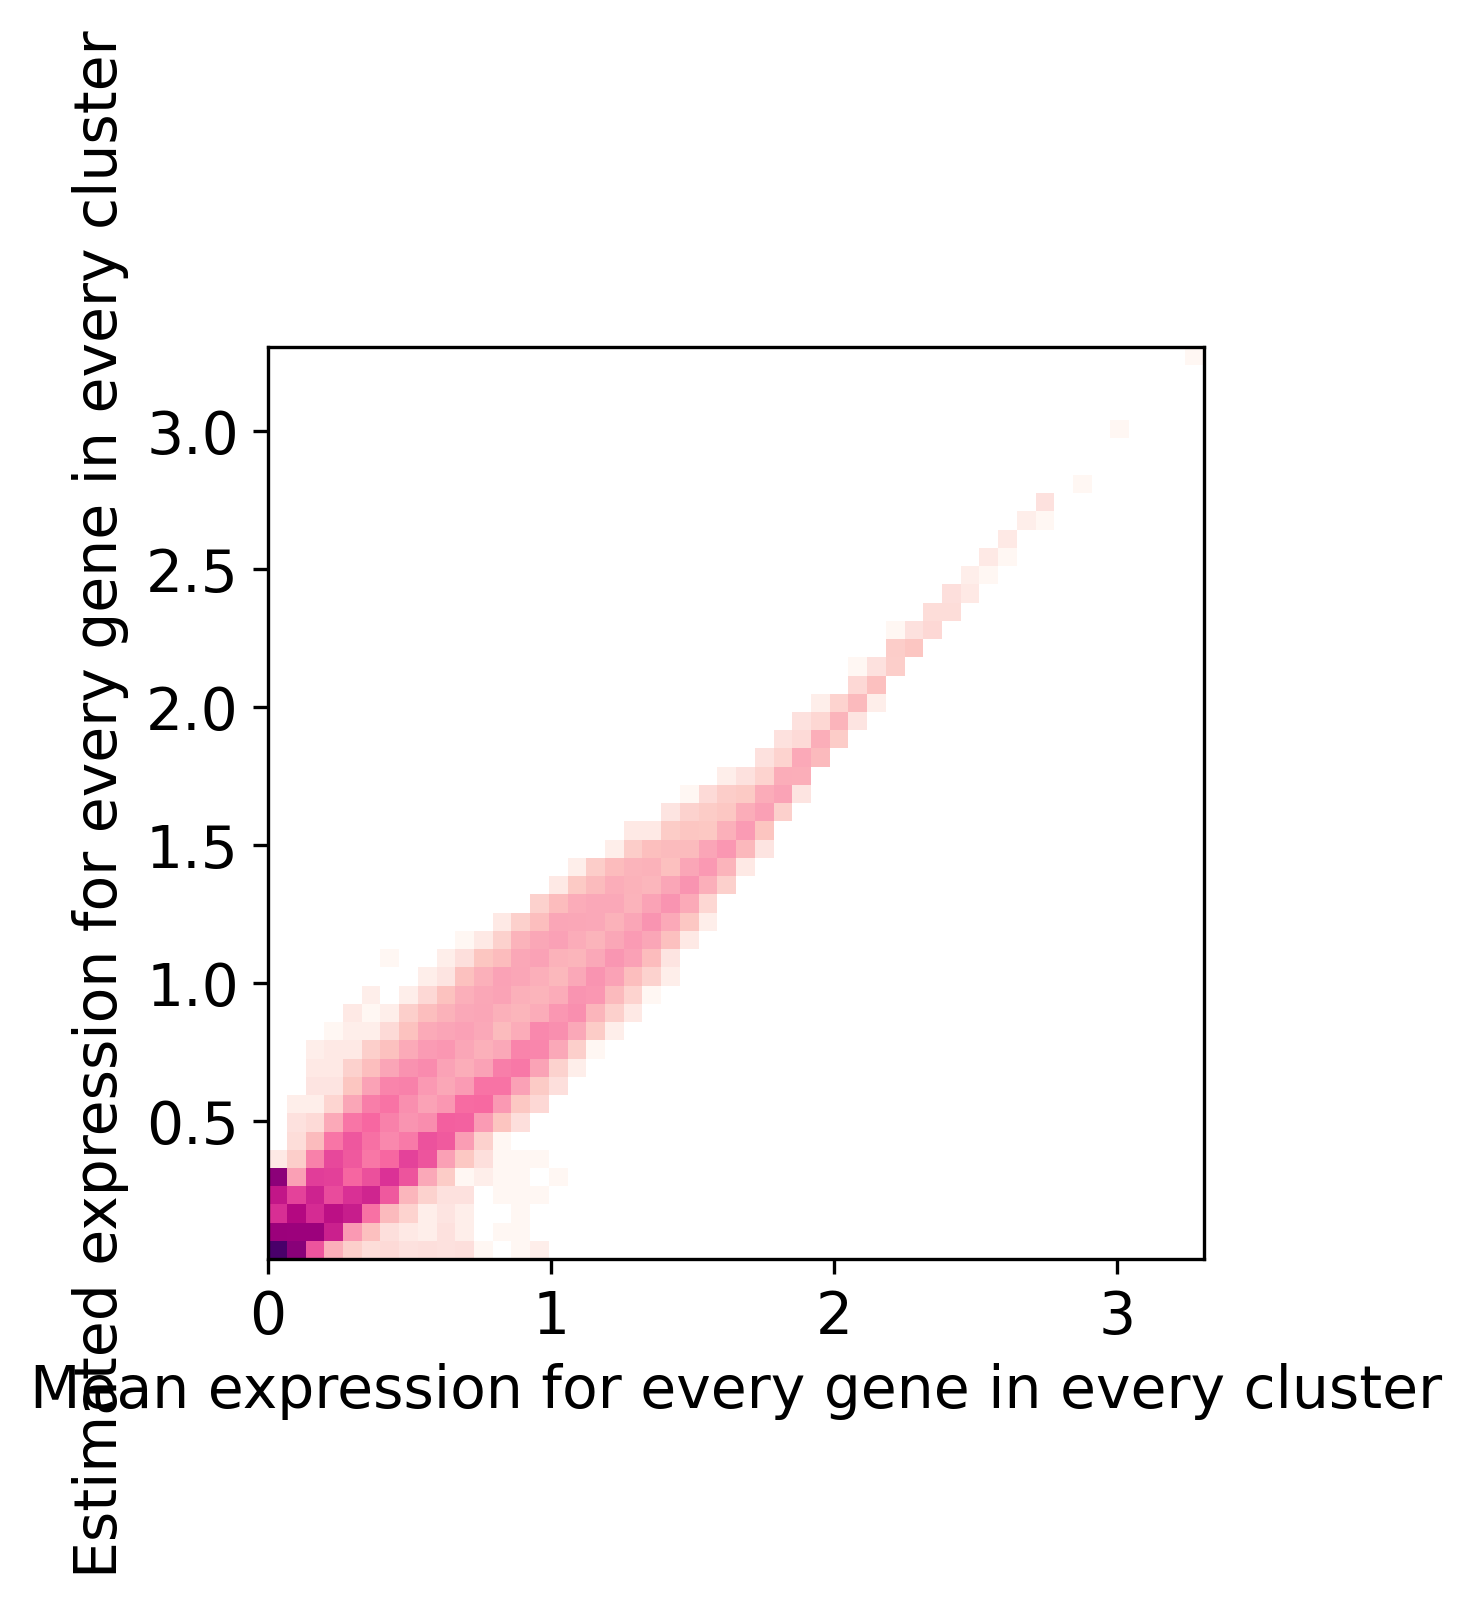

In [18]:
mod.plot_QC()

Examine QC plots

1. Reconstruction accuracy to assess if there are any issues with inference.

2. The estimated expression signatures are distinct from mean expression in each cluster because of batch effects. For scRNA-seq datasets which do not suffer from batch effect (this dataset does), cluster average expression can be used instead of estimating signatures with a model. When this plot is very different from a diagonal plot (e.g. very low values on Y-axis, density everywhere) it indicates problems with signature estimation.

In [19]:
# load single cell file 
adata_ref = sc.read_h5ad(f"{ref_run_name}/sc.h5ad")
adata_ref

AnnData object with n_obs × n_vars = 119141 × 13106
    obs: 'n_genes', 'sample_barcode', 'batch', 'chemistry', 'age_group', 'age_numeric', 'sampleID_TCRab', 'path_TCRab', 'type', 'study', 'sample', 'enrichment', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'barcode_sequence', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'status', 'assignment', 'log_prob_singleton', 'log_prob_doublet', 'louvian_1', 'louvian_05', 'latent_cell_probability', 'latent_RT_efficiency', 'log1p_n_counts', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_r

#read in results of regression model (if notebook is reloaded)
adata_ref = sc.read("/nfs/team205/vk8/scripts/visium/cell2location_v2/results/reference_signatures/sc.h5ad")
adata_vis = sc.read("/nfs/team205/vk8/scripts/visium/cell2location_v2/results/adata_vis_2021-10-01.h5ad")

In [20]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,B-Prolif,B-memory,B-naive,B_pro_pre,CMP
LINC01128,0.066871,0.025358,0.006996,0.092209,0.059416
AL645608.2,0.914146,0.298630,0.753974,0.952167,0.886729
NOC2L,0.290045,0.213394,0.149649,0.547352,0.490903
HES4,0.040693,0.021081,0.011347,0.111840,0.049588
ISG15,3.815374,1.076920,0.981638,1.217245,0.289747


## Cell2location: spatial mapping <a class="anchor" id="cell2location"></a>

In [21]:
#The model and output h5ad can be loaded later like this:
adata_vis_all = sc.read("/nfs/team205/ny1/ThymusSpatialAtlas/Figure2/data/Thymus_atlas_v2_Visium_raw_2023-08-02.h5ad")

In [22]:
adata_vis = adata_vis_all[adata_vis_all.obs['Age_group'] == 'fetal'].copy()

In [33]:
adata_vis_all.shape

(55653, 36601)

In [34]:
adata_vis.shape

(17408, 13106)

In [23]:
for i in adata_vis.uns['spatial'].keys():
    print(f'Deleting images from {i}')
    del adata_vis.uns['spatial'][i]['images']['hires']
    if 'hires5K' in adata_vis.uns['spatial'][i]['images'].keys():
        print("has hires")
        del adata_vis.uns['spatial'][i]['images']['hires5K']
    del adata_vis.uns['spatial'][i]['scalefactors']['tissue_hires5K_scalef']
    del adata_vis.uns['spatial'][i]['scalefactors']['tissue_hires_scalef']

Deleting images from spaceranger122_count_34880_WSSS_THYst9142086_GRCh38-2020-A
has hires
Deleting images from spaceranger122_count_34880_WSSS_THYst9142087_GRCh38-2020-A
Deleting images from spaceranger122_count_34880_WSSS_THYst9142088_GRCh38-2020-A
has hires
Deleting images from spaceranger122_count_34880_WSSS_THYst9142089_GRCh38-2020-A
has hires
Deleting images from spaceranger122_count_36136_WSSS_THYst9518030_GRCh38-2020-A
has hires
Deleting images from spaceranger122_count_36136_WSSS_THYst9518032_GRCh38-2020-A
has hires
Deleting images from spaceranger122_count_36136_WSSS_THYst9518033_GRCh38-2020-A
has hires
Deleting images from spaceranger130_count_36654_WSSS_F_IMMsp9838711_GRCh38-2020-A
has hires
Deleting images from spaceranger130_count_36811_WSSS_F_IMMsp9838716_GRCh38-2020-A
has hires
Deleting images from spaceranger130_count_42337_TA11486161_GRCh38-2020-A
has hires
Deleting images from spaceranger130_count_42337_TA11486162_GRCh38-2020-A
has hires
Deleting images from spacerang

adata_file = f"{ref_run_name}/sp.h5ad"
adata_ref = sc.read('/nfs/team205/vk8/projects/thymus_atlas/results/thymus_atlas_v2_all/reference_signatures/sc.h5ad')

#mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)

In [24]:
# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]
# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()

In [25]:
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]
adata_vis

View of AnnData object with n_obs × n_vars = 17408 × 36588
    obs: 'Sample', 'Sample_hr', 'SampleID', 'SlideID', 'Position', 'in_tissue', 'array_row', 'array_col', 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'percent_mito', 'annotations_level_0', 'annotations_level_0_number', 'annotations_level_1', 'annotations_level_1_number', 'annotations_lobules_0', 'annotations_lobules_0_number', 'L2_dist_annotations_level_0_Artifacts', 'L2_dist_annotations_level_0_Cortex', 'L2_dist_annotations_level_0_Edge', 'L2_dist_annotations_level_0_Medulla', 'L2_dist_annotations_level_1_HS', 'L2_dist_annotations_level_1_PVS', 'L2_dist_annotations_level_1_fat', 'L2_dist_annotations_level_1_vessels', 'L2_dist_annotations_level_0_lymph', 'L2_dist_annotations_level_1_unassigned', 'cm', 'cc', 'cma_v2', 'manual_bin_cma_v2', 'manual_bin_cma_v2_int', 'Image_name', 'Image_jpg', 'section_thickness (um)', 'permebialisation(min)', 'RIN/DV200', 'Visium_type', 'Funding',

In [26]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
#adata_vis = adata_vis[~adata_vis.obs['SampleID'].isin(['S000001583_U11FO2_D1_st9142089',\
#                                                     'V11J11-100_Z1-THY-FO2_A1_TA11486161',\
                                                 #   'V19D02-039_U09-THY-FO1a_C1_st9518032', \
#                                                    ]), intersect].copy()
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

In [27]:
# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="SampleID",
                                                categorical_covariate_keys=['SlideID','section_thickness (um)'],continuous_covariate_keys=['Age(numeric)','n_genes_by_counts'])

Here you need to specify 2 user-provided hyperparameters (`N_cells_per_location` and `detection_alpha`) - for detailed guidance on setting these hyperparameters and their impact see [the flow diagram and the note](https://github.com/BayraktarLab/cell2location/blob/master/docs/images/Note_on_selecting_hyperparameters.pdf).

<div class="alert alert-block alert-danger">
<b>Note!</b>
While you can often use the default value of `detection_alpha` hyperparameter, it is useful to  <b>adapt the expected cell abundance `N_cells_per_location` to every tissue</b>. This value can be estimated from paired histology images and as described in the note above. Change the value presented in this tutorial (`N_cells_per_location=30`) to the value observed in your your tissue.
</div>

In [28]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver, 
    # the expected average cell abundance: tissue-dependent 
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=35,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection (using default here):
    detection_alpha=20
) 

mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.19.0.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'SampleID',
│   'labels_key': None,
│   'categorical_covariate_keys': ['SlideID', 'section_thickness (um)'],
│   'continuous_covariate_keys': ['Age(numeric)', 'n_genes_by_counts']
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  12   │
│         n_cells          │ 17408 │
│ n_extra_categorical_covs │   2   │
│ n_extra_continuous_covs  │   2   │
│         n_labels         │   1   │
│          n_vars          │ 13106 │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│ extra_continuous_covs  │ adata.obsm['_scvi_extra_continuous_covs']  │
│         ind_x          │           adata.obs['_indices']            │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                         batch State Registry                         
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃      Categories      ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['SampleID'] │ WSSS_F_IMMsp9838711  │          0          │
│                       │ WSSS_F_IMMsp9838716  │          1          │
│                       │ WSSS_F_IMMsp10864183 │          2          │
│                       │ WSSS_F_IMMsp11604685 │          3          │
│                       │ WSSS_F_IMMsp11604686 │          4          │
│                       │ WSSS_F_IMMsp11604687 │          5          │
│                       │ WSSS_F_IMMsp11604688 │          6          │
│                       │ WSSS_F_IMMsp11604689 │          7          │
│                       │ WSSS_F_IMMsp11604690 │          8          │
│                       │ WSSS_F_IMMsp11765867 │          9          │
│                       │ WSSS_F_IMMsp11765868 │         10          │
│                       │ WSSS_F_IMMsp11765870 │         11          │
└───────────────────────┴──────────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                  extra_categorical_covs State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃           Source Location           ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│        adata.obs['SlideID']         │ V10U24-023 │          0          │
│                                     │ V10U29-029 │          1          │
│                                     │ V10U29-030 │          2          │
│                                     │ V10U29-031 │          3          │
│                                     │ V11M15-307 │          4          │
│                                     │ V11M15-308 │          5          │
│                                     │            │                     │
│ adata.obs['section_thickness (um)'] │     15     │          0          │
│                                     │            │                     │
└─────────────────────────────────────┴────────────┴─────────────────────┘

   extra_continuous_covs State    
             Registry             
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   adata.obs['Age(numeric)']    │
│ adata.obs['n_genes_by_counts'] │
└────────────────────────────────┘

In [29]:
mod.train(max_epochs=30000, 
          # train using full data (batch_size=None)
          batch_size=None, 
          # use all data points in training because 
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=True)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:105: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-cabed480-71db-8ae2-d02c-e01d42a2060d/0/0]
/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 3/30000:   0%|                                                                       | 2/30000 [00:00<1:07:23,  7.42it/s, v_num=1, elbo_train=2.23e+8]

/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


Epoch 997/30000:   3%|██▏                                                                | 997/30000 [02:05<1:02:44,  7.71it/s, v_num=1, elbo_train=1.35e+8]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 9017/30000:  30%|████████████████████▏                                              | 9016/30000 [19:09<44:15,  7.90it/s, v_num=1, elbo_train=1.25e+8]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 15594/30000:  52%|█████████████████████████████████▊                               | 15593/30000 [33:10<30:42,  7.82it/s, v_num=1, elbo_train=1.25e+8]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 22321/30000:  74%|████████████████████████████████████████████████▎                | 22321/30000 [47:30<16:16,  7.87it/s, v_num=1, elbo_train=1.25e+8]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 28939/30000:  96%|████████████████████████████████████████████████████████████▊  | 28939/30000 [1:01:36<02:15,  7.82it/s, v_num=1, elbo_train=1.25e+8]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
run_name

In [31]:
import os

In [32]:
# Save model and visium data 
adata_file = f"{run_name}/adata_vis.h5ad"
#os.mkdir(run_name)
adata_vis.write(adata_file)
mod.save(f"{run_name}", overwrite=True)


# its best to restart the kernel at this point and load everything again to prevent GPU crashing

In [ ]:

# load model and visium data 
adata_vis = sc.read_h5ad(f"{run_name}/adata_vis.h5ad")
mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

In [ ]:
# load single cell file 
adata_ref = sc.read_h5ad(f"{ref_run_name}/sc.h5ad")
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

In [35]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

Sampling global variables, sample: 100%|██████████████████████████████████████████████████████████████████████████████████| 999/999 [00:24<00:00, 40.00it/s]


In [36]:
# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

'/nfs/team205/vk8/projects/thymus_atlas/results/thymus_atlas_v2_anno_v11_fetal_sub_10K/cell2location_map/sp.h5ad'